<a href="https://colab.research.google.com/github/Junereals/Practice/blob/main/Worms_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmenting worms from the light images

##1. Importing the libraries

In [ ]:
import skimage
from skimage import io, color, filters, measure, morphology, draw, util
from skimage.measure import find_contours
from skimage.restoration import denoise_tv_chambolle
from skimage.filters import threshold_local
from skimage.feature import canny
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
from scipy import ndimage as ndi

In [ ]:
!pip install imagecodecs

##2. Adding the functions

In [ ]:
def outline_object(image):
    # Find edges
    edges = cv2.Canny(image, threshold1=30, threshold2=100)

    # Close the gaps
    kernel = np.ones((7,7), np.uint8)
    closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=3)

    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Close contours with convex hull
    if len(contours) > 1:
        all_points = np.vstack(contours)
        hull = cv2.convexHull(all_points)
        mask = np.zeros_like(image)
        cv2.drawContours(mask, [hull], -1, 255, -1)
    else:
        mask = np.zeros_like(image)
        cv2.drawContours(mask, contours, -1, 255, -1)

    return mask

##3. Mounting google drive (if needed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##4. Loading the image

In [ ]:
# @markdown Copy and insert image path:
image_path = "/content/drive/MyDrive/Worms/Light/DMSO_Image003_ch00.tif" # @param {"type":"string"}
image = imread(image_path)
image_type = '.tif'#@param ['.png','.tif']


##5. Processing the picture
* Converting image to gray
* Canny edge detection algorithm
* Finding contours
* Filling the contours (if needed)

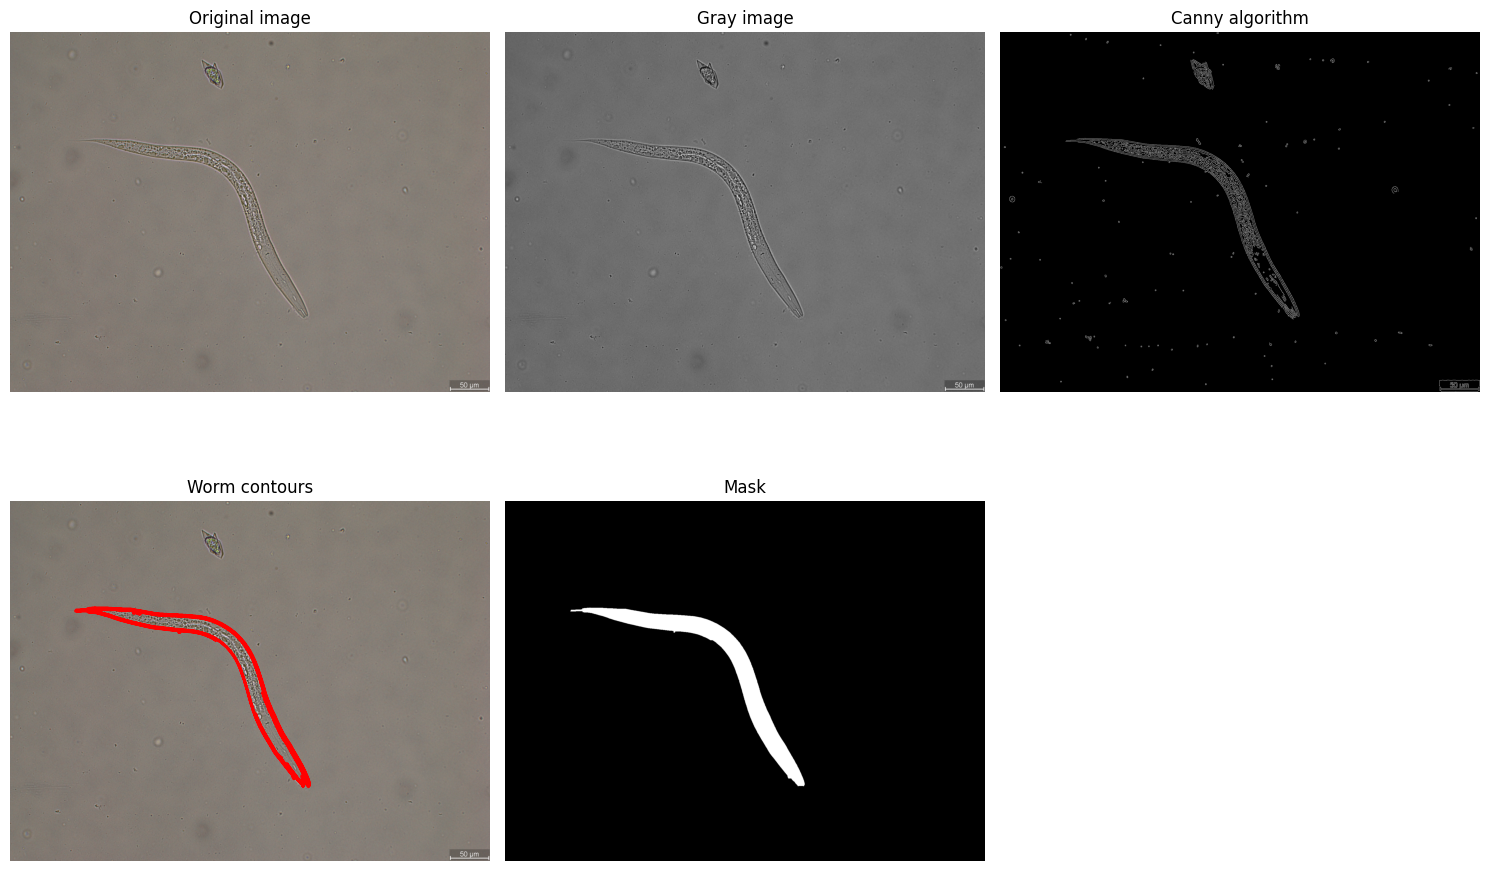

In [ ]:
gray = rgb2gray(image)
canny_edges = canny(gray, sigma=1.5)
contours = sorted(find_contours(canny_edges,fully_connected='low'),key=len,reverse=True)
filled_gray = ndi.binary_fill_holes(canny_edges)
binary_mask = filled_gray > 0
contours = find_contours(binary_mask,fully_connected='high')
#@markdown Minimum length of the worm for segmentation
length = 1100#@param
cont_image = np.zeros((image.shape)[:2], dtype=np.uint8)
contour = [x.reshape(-1, 2) for x in sorted(contours,key=len) if len(x)>length]
for c in contour:
  rr, cc = draw.polygon(c[:, 0], c[:, 1], cont_image.shape)
  cont_image[rr, cc] = 255
mask = outline_object(cont_image)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(image)
axes[0, 0].set_title('Original image')
axes[0, 0].axis('off')

axes[0, 1].imshow(gray, cmap='gray')
axes[0, 1].set_title('Gray image')
axes[0, 1].axis('off')

axes[0, 2].imshow(canny_edges, cmap='gray')
axes[0, 2].set_title('Canny algorithm')
axes[0, 2].axis('off')

axes[1,0].imshow(image, cmap=plt.cm.gray)
for cont in contour:
  axes[1,0].plot(cont[:, 1], cont[:, 0], linewidth=2, color="red")
axes[1, 0].set_title('Worm contours')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask, cmap='gray')
axes[1, 1].set_title('Mask')
axes[1, 1].axis('off')
fig.delaxes(axes[1, 2])
plt.tight_layout()

## 6. Downloading the mask of the image

In [ ]:
#@markdown The mask will be saved in the same folder as the image
cv2.imwrite(image_path.replace(image_type, '_mask.png'), mask)

True

# Segmenting worms from the green channel

##1. Loading the image

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, filters, measure
from scipy import ndimage
from skimage.morphology import remove_small_holes
# @markdown Copy and insert image path:
image_path = "/content/drive/MyDrive/Worms/Green/Copy of sample 4_Image006_ch00.tif" # @param {"type":"string"}
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_type = '.tif'#@param ['.png','.tif']

##2. Processing the image
* Isolating the green channel
* Enchancing the contrast by CLAHE
* Removing holes and small objects
* Finding contours
* Drawing mask

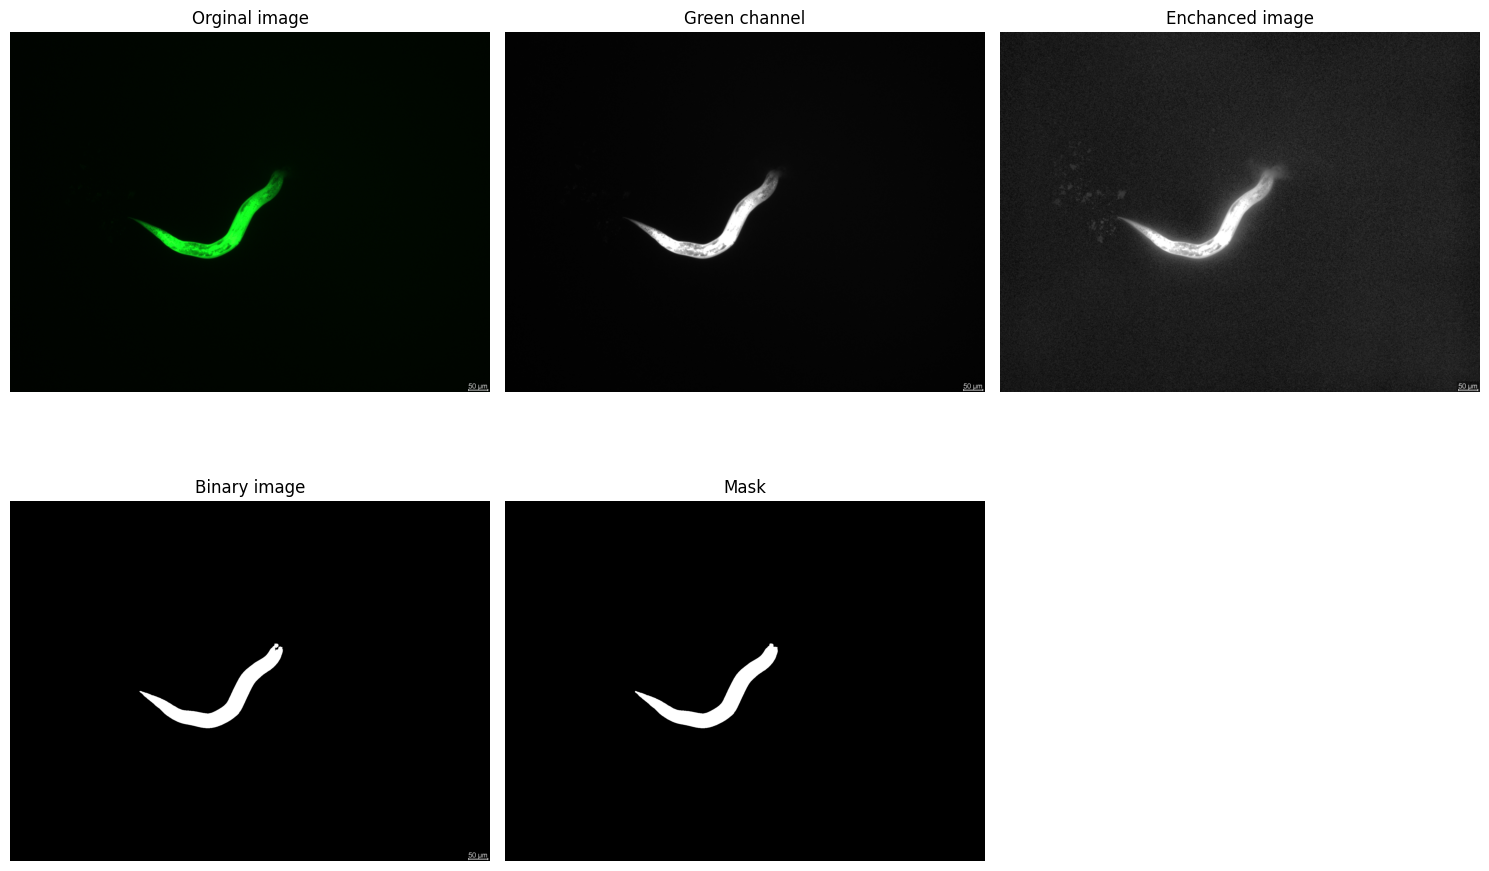

In [ ]:
green_channel = img_rgb[:, :, 1]
clahe = cv2.createCLAHE(clipLimit=12.0, tileGridSize=(8,8))
enhanced = clahe.apply(green_channel)
_, thresh = cv2.threshold(enhanced, 50, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)
kernel = np.ones((3,3), np.uint8)
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=2)
#@markdown Minimal worm size:
min_size = 100 #@param
cleaned = morphology.remove_small_objects(
        opened.astype(bool),
        min_size=min_size,
        connectivity=2
    ).astype(np.uint8) * 255
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
from skimage.morphology import remove_small_holes
filled = remove_small_holes(
    cleaned.astype(bool),
    area_threshold=10
).astype(np.uint8) * 255
contours, hierarchy = cv2.findContours(filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = [x for x in contours if len(x) >= min_size]
mask = np.zeros_like(green_channel)
cv2.drawContours(mask, contours, -1, 255, thickness=cv2.FILLED)
#Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0, 0].imshow(img_rgb)
axes[0, 0].set_title('Orginal image')
axes[0, 0].axis('off')

axes[0, 1].imshow(green_channel, cmap='gray')
axes[0, 1].set_title('Green channel')
axes[0, 1].axis('off')

axes[0, 2].imshow(enhanced, cmap='gray')
axes[0, 2].set_title('Enchanced image')
axes[0, 2].axis('off')

axes[1, 0].imshow(thresh, cmap='gray')
axes[1, 0].set_title('Binary image')
axes[1, 0].axis('off')

axes[1, 1].imshow(mask, cmap='gray')
axes[1, 1].set_title('Mask')
axes[1, 1].axis('off')
fig.delaxes(axes[1, 2])
plt.tight_layout()

##3. Downloading the mask

In [ ]:
#@markdown The mask will be saved in the same folder as the image
cv2.imwrite(image_path.replace(image_type, '_mask.png'), mask)

True

#Calculating parameters from mask

In [ ]:
#@markdown Image parameters calculation

#@markdown Provide path of the mask:
path = "/content/drive/MyDrive/Worms/Green/Copy of sample 4_Image006_ch00_mask.png" # @param {"type":"string"}
mask = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#@markdown To calculate in µm, input scalebar information (put 1 if not needed):
scalebar_length_px = 98 #@param
scalebar_length_nm = 10 #@param
px_to_nm=scalebar_length_nm/scalebar_length_px
for contour in contours:
  area = cv2.contourArea(contour)
  area_nm = area * px_to_nm ** 2
  mask_worm = np.zeros_like(mask)
  cv2.drawContours(mask_worm, [contour], -1, 255, thickness=cv2.FILLED)
  print(f'Area of the worm: {area} px ==> {round(area_nm,3)} µm^2')
  if len(mask_worm.shape) > 2:
      mask_worm = cv2.cvtColor(mask_worm, cv2.COLOR_BGR2GRAY)
  _, binary_mask = cv2.threshold(mask_worm, 127, 255, cv2.THRESH_BINARY)
  # Skeletonize the mask
  binary_mask = binary_mask > 0
  skeleton = skeletonize(binary_mask,method='lee')
  # Calculate length from skeleton
  length_pixels = np.sum(skeleton)
  # Calculate average width using area/length
  area_pixels = np.sum(binary_mask)
  avg_width_pixels = round(area_pixels / length_pixels,3) if length_pixels > 0 else 0
  print(f'Length: {length_pixels} px ==> {round(length_pixels*px_to_nm,3)} µm')
  print(f'Avg. width: {avg_width_pixels} px ==> {round(avg_width_pixels*px_to_nm,3)} µm')


image = cv2.imread(path.replace("_mask.png",image_type))
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_cv2 = img_rgb[:, :, 1]
object_intensities = gray_cv2[mask]
stats = {
    'mean intensity': np.mean(object_intensities),
    'median intensity': np.median(object_intensities),
    'min intensity': np.min(object_intensities),
    'max intensity': np.max(object_intensities)
    }
for key, value in stats.items():
    print(f'{key.capitalize()}: {round(value,3)}')

Area of the worm: 38015.0 px ==> 395.825 µm^2
Length: 634 px ==> 64.694 µm
Avg. width: 61.011 px ==> 6.226 µm
Mean intensity: 6.435
Median intensity: 7.0
Min intensity: 4
Max intensity: 10
